# Car Insurance Claim EDA

## Aim of the project:

To understand the various factors that make a customer claim for a car insurance and to build a ML model to predict whether the customer makes a claim in the next six months based on the given features

## Data Source:

Kaggle dataset link: https://www.kaggle.com/datasets/ifteshanajnin/carinsuranceclaimprediction-classification

Dataset consists of three files: train.csv, test.csv and sample_submission.csv

## 1. Importing the relevant libraries

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

warnings.filterwarnings("ignore")
sns.set()

## 2. Loading the data

In [111]:
train_df = pd.read_csv('train.csv')
train_df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [112]:
train_df.shape

(58592, 44)

## 3. Data Exploration

Data Exploration will involve the following steps:
- Check for missing values
- Check for duplicate values
- Check for imbalance
- Check data types and number of unique values for each column
- Check statistics of numerical data
- Check various categories for the categorical features

### 3.1 Check for missing values

In [113]:
train_df.isna().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

No missing values were found

### 3.2 Checking for duplicate values

In [114]:
train_df.duplicated().sum()

0

No duplicate values were found

### 3.3 Checking for imbalance in target variable

In [115]:
train_df['is_claim'].value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

There is massive imbalance. We will over-sample the data later.

### 3.3 Checking data types

In [116]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

### 3.4 Checking for number of unique values for each categorical column

In [117]:
train_df.select_dtypes(include='object').nunique()

policy_id                           58592
area_cluster                           22
segment                                 6
model                                  11
fuel_type                               3
max_torque                              9
max_power                               9
engine_type                            11
is_esc                                  2
is_adjustable_steering                  2
is_tpms                                 2
is_parking_sensors                      2
is_parking_camera                       2
rear_brakes_type                        2
transmission_type                       2
steering_type                           3
is_front_fog_lights                     2
is_rear_window_wiper                    2
is_rear_window_washer                   2
is_rear_window_defogger                 2
is_brake_assist                         2
is_power_door_locks                     2
is_central_locking                      2
is_power_steering                 

### 3.5 Checking statistics of numerical columns

In [118]:
train_df.select_dtypes(exclude='object').describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


- age_of_car and age_of_policyholder have already been normalized
- make, airbags and, ncap_rating can be converted to categorical columns

### 3.6 Checking the various categories of the categorical columns

In [119]:
categorical_df = train_df.select_dtypes(include='object')
for column in categorical_df.columns:
    if categorical_df[column].nunique()>1:
        print(column)
        print(categorical_df[column].unique())
        print("-----------------------------------------")

policy_id
['ID00001' 'ID00002' 'ID00003' ... 'ID58590' 'ID58591' 'ID58592']
-----------------------------------------
area_cluster
['C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13'
 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22']
-----------------------------------------
segment
['A' 'C1' 'C2' 'B2' 'B1' 'Utility']
-----------------------------------------
model
['M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'M10' 'M11']
-----------------------------------------
fuel_type
['CNG' 'Petrol' 'Diesel']
-----------------------------------------
max_torque
['60Nm@3500rpm' '113Nm@4400rpm' '91Nm@4250rpm' '250Nm@2750rpm'
 '200Nm@3000rpm' '82.1Nm@3400rpm' '200Nm@1750rpm' '85Nm@3000rpm'
 '170Nm@4000rpm']
-----------------------------------------
max_power
['40.36bhp@6000rpm' '88.50bhp@6000rpm' '67.06bhp@5500rpm'
 '113.45bhp@4000rpm' '88.77bhp@4000rpm' '55.92bhp@5300rpm'
 '97.89bhp@3600rpm' '61.68bhp@6000rpm' '118.36bhp@5500rpm']
-----------------------------------------
en

In [120]:
print(list(train_df.columns.values))

['policy_id', 'policy_tenure', 'age_of_car', 'age_of_policyholder', 'area_cluster', 'population_density', 'make', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power', 'engine_type', 'airbags', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder', 'transmission_type', 'gear_box', 'steering_type', 'turning_radius', 'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim']


## Feature Selection and Feature Engineering

In [121]:
#Making a numerical and categorical df for further analysis
numerical_df = train_df.select_dtypes(exclude='object')
categorical_df = train_df.select_dtypes(include='object')

### Numerical Features

Checking the correlation between the various features

<AxesSubplot: >

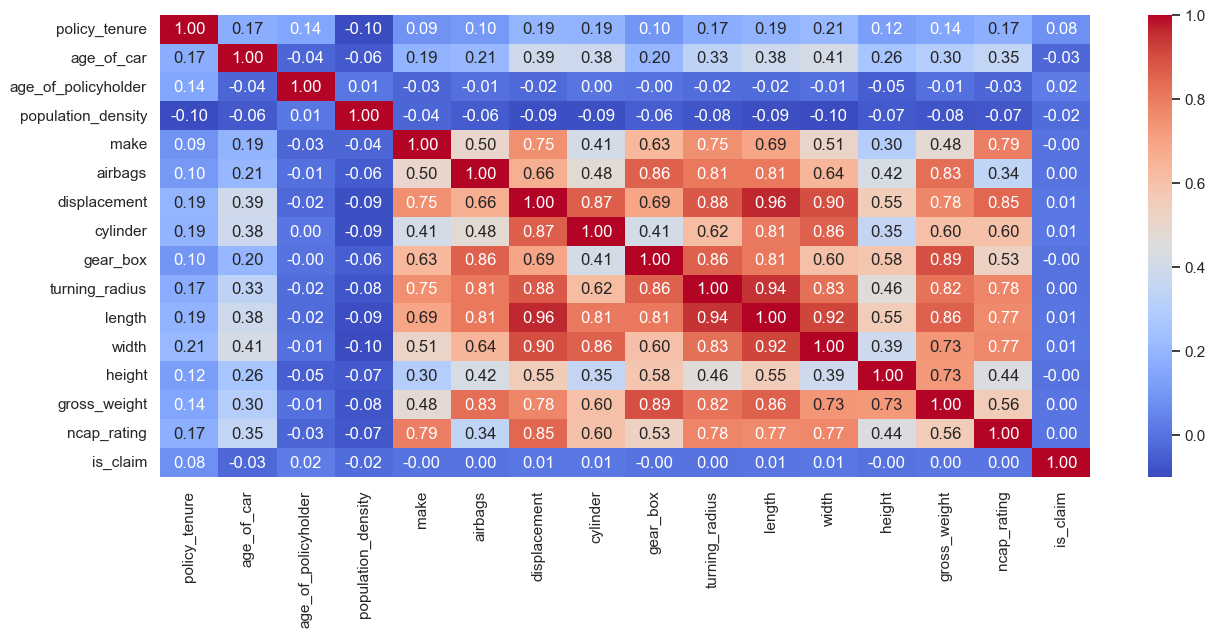

In [122]:
plt.figure(figsize=(15,6))
corr_matrix=numerical_df.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt='.2f')

In [123]:
len(corr_matrix.columns.values)

16

In [124]:
# Filter the matrix to get highly correlated features
threshold = 0.70
highly_correlated_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i+1,len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            #print(f"{corr_matrix.columns[i]}-{corr_matrix.columns[j]}")
            highly_correlated_features.add(corr_matrix.columns[i])
            highly_correlated_features.add(corr_matrix.columns[j])

print(highly_correlated_features)

{'displacement', 'gear_box', 'make', 'cylinder', 'length', 'ncap_rating', 'width', 'gross_weight', 'airbags', 'turning_radius', 'height'}


Combining the highly correlated features using PCA

In [125]:
numerical_df_copy = numerical_df.copy()

In [126]:
subset = numerical_df_copy[highly_correlated_features]

# Perform PCA on the subset of data
pca = PCA(n_components=4)
pca_result = pca.fit_transform(subset)

# Create a new dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2','PC3','PC4'])

# Concatenate the original dataframe with the PCA dataframe
numerical_df_copy = pd.concat([numerical_df_copy, pca_df], axis=1)
numerical_df_copy.drop(highly_correlated_features,axis=1,inplace=True)

<AxesSubplot: >

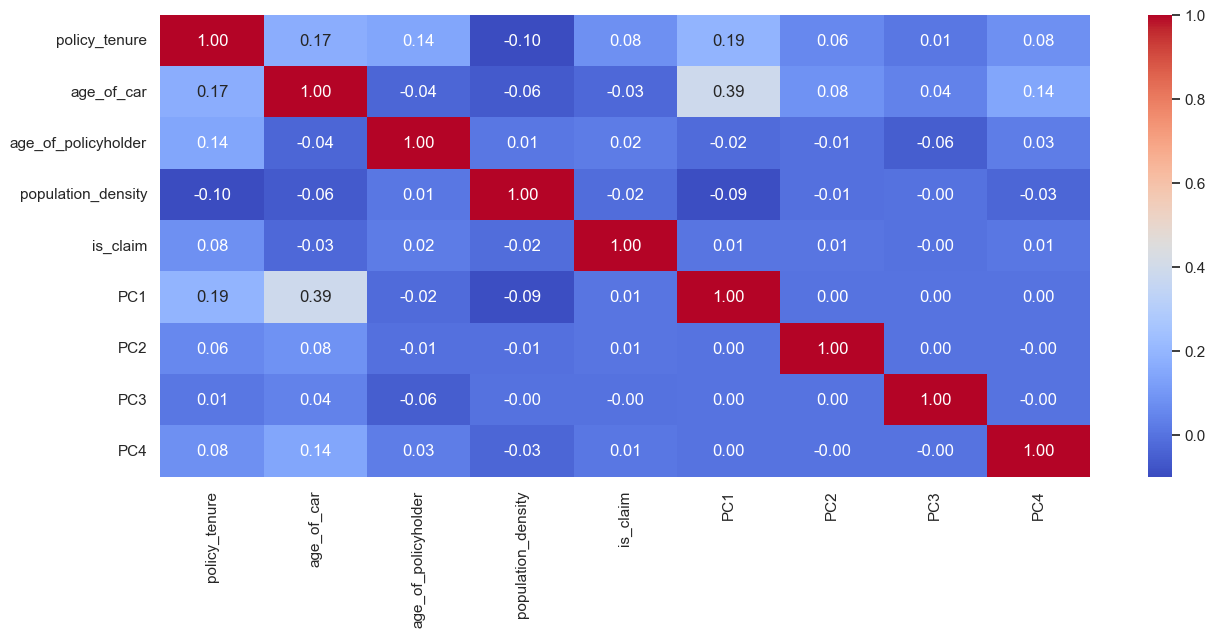

In [127]:
plt.figure(figsize=(15,6))
sns.heatmap(numerical_df_copy.corr(), cmap="coolwarm", annot=True, fmt='.2f')

## Combining categorical features to reduce dimensionality

In [128]:
categorical_df_copy = categorical_df.copy()
categorical_df_copy.head()

,policy_id,area_cluster,segment,model,fuel_type,max_torque,max_power,engine_type,is_esc,is_adjustable_steering,...,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
0,ID00001,C1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,No,No,...,No,No,No,No,No,Yes,No,No,No,Yes
1,ID00002,C2,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,No,No,...,No,No,No,No,No,Yes,No,No,No,Yes
2,ID00003,C3,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,No,No,...,No,No,No,No,No,Yes,No,No,No,Yes
3,ID00004,C4,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,Yes,Yes,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,ID00005,C5,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,No,No,...,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes


In [129]:
#Label encoding features with binary values
pattern = re.compile(r'^is_')
binary_features = [feature for feature in categorical_df.columns.values if pattern.match(feature)]
for feature in binary_features:
    categorical_df_copy[feature] = categorical_df_copy[feature].map({'Yes':'1','No':'0'})
categorical_df_copy.head()

,policy_id,area_cluster,segment,model,fuel_type,max_torque,max_power,engine_type,is_esc,is_adjustable_steering,...,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
0,ID00001,C1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,0,0,...,0,0,0,0,0,1,0,0,0,1
1,ID00002,C2,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,0,0,...,0,0,0,0,0,1,0,0,0,1
2,ID00003,C3,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,0,0,...,0,0,0,0,0,1,0,0,0,1
3,ID00004,C4,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,1,1,...,0,1,1,1,1,1,1,1,1,1
4,ID00005,C5,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,0,0,...,0,0,0,1,1,1,0,1,1,1


In [130]:
max_rating,car_details,car_name=[],[],[]
steering,locking,rear_window,parking,dashboard=[],[],[],[],[]
for index,row in categorical_df_copy.iterrows():
    car_details.append(f"{row['engine_type']} {row['rear_brakes_type']} {row['transmission_type']} {row['steering_type']} {row['fuel_type']}")
    car_name.append(f"{row['segment']} {row['model']}")
    max_rating.append(f"{row['max_torque']} {row['max_power']}")
    steering.append(str(int(row['is_adjustable_steering'])+int(row['is_power_steering'])))
    locking.append(str(int(row['is_power_door_locks'])+int(row['is_central_locking'])))
    rear_window.append(str(int(row['is_rear_window_wiper'])+int(row['is_rear_window_washer'])+int(row['is_rear_window_defogger'])))
    parking.append(str(int(row['is_parking_sensors'])+int(row['is_parking_camera'])))
    dashboard.append(str(int(row['is_tpms'])+int(row['is_ecw'])+int(row['is_speed_alert'])))

In [131]:
columns_to_drop = ['engine_type','rear_brakes_type','transmission_type','steering_type','model','segment','max_power','max_torque','fuel_type','is_adjustable_steering','is_power_steering','is_power_door_locks','is_central_locking','is_rear_window_wiper','is_rear_window_washer','is_rear_window_defogger','is_parking_sensors','is_parking_camera','is_tpms','is_ecw','is_speed_alert']

categorical_df_copy.drop(columns_to_drop,axis=1,inplace=True)

categorical_df_copy['max_rating'] = max_rating
categorical_df_copy['car_details'] = car_details
categorical_df_copy['car_name'] = car_name
categorical_df_copy['steering'] = steering
categorical_df_copy['locking'] = locking
categorical_df_copy['rear_window'] = rear_window
categorical_df_copy['parking'] = parking
categorical_df_copy['dashboard'] = dashboard

In [132]:
categorical_df_copy.head()

,policy_id,area_cluster,is_esc,is_front_fog_lights,is_brake_assist,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,max_rating,car_details,car_name,steering,locking,rear_window,parking,dashboard
0,ID00001,C1,0,0,0,0,0,60Nm@3500rpm 40.36bhp@6000rpm,F8D Petrol Engine Drum Manual Power CNG,A M1,1,0,0,1,1
1,ID00002,C2,0,0,0,0,0,60Nm@3500rpm 40.36bhp@6000rpm,F8D Petrol Engine Drum Manual Power CNG,A M1,1,0,0,1,1
2,ID00003,C3,0,0,0,0,0,60Nm@3500rpm 40.36bhp@6000rpm,F8D Petrol Engine Drum Manual Power CNG,A M1,1,0,0,1,1
3,ID00004,C4,1,1,1,1,1,113Nm@4400rpm 88.50bhp@6000rpm,1.2 L K12N Dualjet Drum Automatic Electric Petrol,C1 M2,2,2,1,2,2
4,ID00005,C5,0,0,0,0,1,91Nm@4250rpm 67.06bhp@5500rpm,1.0 SCe Drum Automatic Electric Petrol,A M3,1,2,0,1,2


Dropping the policy_id column

In [133]:
categorical_df_copy.drop('policy_id',axis=1,inplace=True)

Merging the updated numerical and categorical features

In [134]:
final_train_df = pd.concat([numerical_df_copy,categorical_df_copy],axis=1)
final_train_df.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,is_claim,PC1,PC2,PC3,PC4,area_cluster,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,max_rating,car_details,car_name,steering,locking,rear_window,parking,dashboard
0,0.515874,0.05,0.644231,4990,0,-604.868716,-49.603058,-22.703923,-17.944961,C1,...,0,0,60Nm@3500rpm 40.36bhp@6000rpm,F8D Petrol Engine Drum Manual Power CNG,A M1,1,0,0,1,1
1,0.672619,0.02,0.375000,27003,0,-604.868716,-49.603058,-22.703923,-17.944961,C2,...,0,0,60Nm@3500rpm 40.36bhp@6000rpm,F8D Petrol Engine Drum Manual Power CNG,A M1,1,0,0,1,1
2,0.841110,0.02,0.384615,4076,0,-604.868716,-49.603058,-22.703923,-17.944961,C3,...,0,0,60Nm@3500rpm 40.36bhp@6000rpm,F8D Petrol Engine Drum Manual Power CNG,A M1,1,0,0,1,1
3,0.900277,0.11,0.432692,21622,0,106.037246,97.647926,-72.804443,-24.980532,C4,...,1,1,113Nm@4400rpm 88.50bhp@6000rpm,1.2 L K12N Dualjet Drum Automatic Electric Petrol,C1 M2,2,2,1,2,2
4,0.596403,0.11,0.634615,34738,0,-294.535342,104.494177,-23.365832,-80.880562,C5,...,0,1,91Nm@4250rpm 67.06bhp@5500rpm,1.0 SCe Drum Automatic Electric Petrol,A M3,1,2,0,1,2


## Encoding and Scaling

In [135]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_tenure                     58592 non-null  float64
 1   age_of_car                        58592 non-null  float64
 2   age_of_policyholder               58592 non-null  float64
 3   population_density                58592 non-null  int64  
 4   is_claim                          58592 non-null  int64  
 5   PC1                               58592 non-null  float64
 6   PC2                               58592 non-null  float64
 7   PC3                               58592 non-null  float64
 8   PC4                               58592 non-null  float64
 9   area_cluster                      58592 non-null  object 
 10  is_esc                            58592 non-null  object 
 11  is_front_fog_lights               58592 non-null  object 
 12  is_b

In [136]:
X = final_train_df.drop('is_claim',axis=1)
y = final_train_df['is_claim']

In [137]:
#Reversing the Min-Max Scaling of age_of_car and age_of_policyholder
features_to_reverse = ['age_of_car','age_of_policyholder']
for feature in features_to_reverse:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(X[[feature]])
    X[feature] = scaler.inverse_transform(scaled_data)

In [138]:
def one_hot_encoding(df,column):
    encoder = OneHotEncoder(drop='first')
    encoded_array = encoder.fit_transform(df[[column]]).toarray()
    encoded_df = pd.DataFrame(data=encoded_array,columns=encoder.get_feature_names([column]))
    return encoded_df

In [139]:
def standard_scaler(df,column):
    scaler=StandardScaler()
    return scaler.fit_transform(df[[column]])

In [140]:
X_transformed = X.copy()
for column in X:
    if X[column].dtype=='object':
        encoded_df = one_hot_encoding(X,column)
        X_transformed = pd.concat([X_transformed,encoded_df],axis=1)
        X_transformed.drop(column,axis=1,inplace=True)
    else:
        X_transformed[column] = standard_scaler(X,column)
X_transformed.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,PC1,PC2,PC3,PC4,area_cluster_C10,area_cluster_C11,...,car_name_C2 M4,car_name_Utility M10,steering_1,steering_2,locking_2,rear_window_1,rear_window_3,parking_2,dashboard_2,dashboard_3
0,-0.230283,-0.342447,1.422557,-0.783513,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.148188,-0.871359,-0.768362,0.462975,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.555022,-0.871359,-0.690115,-0.835268,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.697883,0.715378,-0.298879,0.158275,0.230719,0.825208,-1.132006,-0.651615,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
4,-0.035840,0.715378,1.344310,0.900969,-0.640859,0.883065,-0.363306,-2.109764,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## OverSampling the target column

In [144]:
adasyn = ADASYN()
# Fit and transform the data using ADASYN oversampling
X_resampled, y_resampled = adasyn.fit_resample(X_transformed.values, y.values)

In [145]:
X_resampled

array([[-0.23028345, -0.34244685,  1.42255728, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14818765, -0.87135928, -0.7683621 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55502223, -0.87135928, -0.69011498, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.08429285, -0.20604235, -1.04593414, ...,  1.        ,
         0.        ,  1.        ],
       [-1.2562259 ,  0.44107005, -0.3684729 , ...,  1.        ,
         0.        ,  1.        ],
       [-1.25674528,  0.10893417, -0.60432602, ...,  1.        ,
         0.        ,  1.        ]])

In [146]:
X_resampled_df = pd.DataFrame(X_resampled, columns=[f"feature_{i}" for i in range(X_resampled.shape[1])])
y_resampled_df = pd.DataFrame(y_resampled, columns=["target"])
pd.concat([X_resampled_df,y_resampled_df],axis=1)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,target
0,-0.230283,-0.342447,1.422557,-0.783513,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.148188,-0.871359,-0.768362,0.462975,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.555022,-0.871359,-0.690115,-0.835268,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.697883,0.715378,-0.298879,0.158275,0.230719,0.825208,-1.132006,-0.651615,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0
4,-0.035840,0.715378,1.344310,0.900969,-0.640859,0.883065,-0.363306,-2.109764,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110373,-1.192091,-0.290960,-0.970558,0.900969,1.438841,-0.655310,-0.208472,-0.573204,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1
110374,-1.133739,-0.244994,-1.011360,0.900969,1.438841,-0.655310,-0.208472,-0.573204,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1
110375,-1.084293,-0.206042,-1.045934,0.900969,1.438841,-0.655310,-0.208472,-0.573204,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1
110376,-1.256226,0.441070,-0.368473,0.900969,1.438841,-0.655310,-0.208472,-0.573204,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1


## Train-Test Split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y,test_size=0.20,random_state=24,shuffle=True,stratify=y)

In [96]:
#Making a validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.15,random_state=42,shuffle=True,stratify=y_train)

In [97]:
print(f"Train data X:{X_train.shape} y:{y_train.shape}")
print(f"Validation data X:{X_val.shape} y:{y_val.shape}")
print(f"Test data X:{X_test.shape} y:{y_test.shape}")

Train data X:(39842, 70) y:(39842,)
Validation data X:(7031, 70) y:(7031,)
Test data X:(11719, 70) y:(11719,)


In [98]:
print(f"Train: {y_train.value_counts()}")
print(f"Validation: {y_val.value_counts()}")
print(f"Test: {y_test.value_counts()}")

Train: 0    37294
1     2548
Name: is_claim, dtype: int64
Validation: 0    6581
1     450
Name: is_claim, dtype: int64
Test: 0    10969
1      750
Name: is_claim, dtype: int64


## Model Training

In [99]:
def evaluate_model(true, predicted):
    accuracy = accuracy_score(true,predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    f1 = f1_score(true, predicted)
    roc = roc_auc_score(true,predicted)

    return accuracy, precision, recall, f1, roc

In [100]:
model = LogisticRegression()
params = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(model,params,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']})

In [101]:
grid_search.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [39]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)),
    "CatBoost": CatBoostClassifier(),
    "GradientBoost": GradientBoostingClassifier()
}

model_list=[]

for model_name,model in models.items():

    print(f"Model name: {model_name}")

    start_time = time.time()
    algo = model
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_val)
    accuracy, precision, recall, f1, roc = evaluate_model(y_val,y_pred)
    end_time = time.time()

    elapsed_time = end_time-start_time

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, f1-score: {f1:.3f}")
    print(f"ROC-AUC score: {roc:.3f}")
    print("-----------------------------------------------------------------------------")

    model_list.append([model_name,accuracy,precision,recall,f1,roc,elapsed_time])

Model name: Logistic Regression
Accuracy: 0.936
Precision: 0.000, Recall: 0.000, f1-score: 0.000
ROC-AUC score: 0.500
-----------------------------------------------------------------------------
Model name: K-Neighbors
Accuracy: 0.932
Precision: 0.036, Recall: 0.002, f1-score: 0.004
ROC-AUC score: 0.499
-----------------------------------------------------------------------------
Model name: Decision Tree
Accuracy: 0.872
Precision: 0.075, Recall: 0.089, f1-score: 0.082
ROC-AUC score: 0.507
-----------------------------------------------------------------------------
Model name: Random Forest
Accuracy: 0.930
Precision: 0.044, Recall: 0.004, f1-score: 0.008
ROC-AUC score: 0.499
-----------------------------------------------------------------------------
Model name: XGBoost
Accuracy: 0.936
Precision: 0.000, Recall: 0.000, f1-score: 0.000
ROC-AUC score: 0.500
-----------------------------------------------------------------------------
Model name: AdaBoost
Accuracy: 0.936
Precision: 0.00

In [40]:
models_stats_df = pd.DataFrame(data=model_list,columns=['Model name','Accuracy','Precision','Recall','f1-score','ROC-AUC score','Time (in seconds)'])
models_stats_df

,Model name,Accuracy,Precision,Recall,f1-score,ROC-AUC score,Time (in seconds)
0,Logistic Regression,0.935998,0.000000,0.000000,0.000000,0.500000,1.572707
1,K-Neighbors,0.932300,0.035714,0.002222,0.004184,0.499060,9.395015
2,Decision Tree,0.871995,0.075472,0.088889,0.081633,0.507216,1.359057
3,Random Forest,0.930166,0.044444,0.004444,0.008081,0.498955,9.493685
4,XGBoost,0.935571,0.000000,0.000000,0.000000,0.499772,4.312692
5,AdaBoost,0.935855,0.000000,0.000000,0.000000,0.499924,3.261924
6,CatBoost,0.935998,0.500000,0.004444,0.008811,0.502070,11.551633
7,GradientBoost,0.935855,0.000000,0.000000,0.000000,0.499924,10.040285


### Using XGBoost as our ML model since it provides the best result in the least time

In [ ]:
# Define the XGBoost classifier
xgb = XGBClassifier()

params = {
    'learning_rate': np.linspace(0.001, 0.3, 10),
    'max_depth': range(2, 10),
    'n_estimators': range(50, 500, 20),
    'subsample': np.linspace(0, 1, 5),
    'colsample_bytree': np.linspace(0, 1, 5),
    'reg_alpha': np.linspace(0, 1, 4),
    'reg_lambda': np.linspace(0, 1, 4)
}

# Perform randomized search cross-validation to find the best hyper-parameters
grid_search = GridSearchCV(xgb, params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyper-parameters and their corresponding score
print("Best hyper-parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle

# Load the dataset
data = pd.read_csv('car_insurance_claim.csv')

# Split the dataset into features and target variable
X = data.drop('CLAIM_FLAG', axis=1)
y = data['CLAIM_FLAG']

# Define the model
xgb_model = XGBClassifier(random_state=42)

# Define the parameter grid for hyper-parameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Define the cross-validation object
k_fold = 5

# Use GridSearchCV for hyper-parameter tuning with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=k_fold, n_jobs=-1)

# Fit the model with GridSearchCV
grid_search.fit(X, y)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Save the model in a pickle file
filename = 'xgb_model.pkl'
pickle.dump(grid_search, open(filename, 'wb'))


In [43]:
num_df = train_df.select_dtypes(exclude='object')
scaler = StandardScaler()
arr = scaler.fit_transform(num_df[num_df.columns.values])

In [44]:
num_df[num_df.columns.values]

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
0,0.515874,0.05,0.644231,4990,1,2,796,3,5,4.6,3445,1515,1475,1185,0,0
1,0.672619,0.02,0.375000,27003,1,2,796,3,5,4.6,3445,1515,1475,1185,0,0
2,0.841110,0.02,0.384615,4076,1,2,796,3,5,4.6,3445,1515,1475,1185,0,0
3,0.900277,0.11,0.432692,21622,1,2,1197,4,5,4.8,3995,1735,1515,1335,2,0
4,0.596403,0.11,0.634615,34738,2,2,999,3,5,5.0,3731,1579,1490,1155,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.355089,0.13,0.644231,8794,2,2,999,3,5,5.0,3731,1579,1490,1155,2,0
58588,1.199642,0.02,0.519231,7788,1,2,796,3,5,4.6,3445,1515,1475,1185,0,0
58589,1.162273,0.05,0.451923,34738,1,2,796,3,5,4.6,3445,1515,1475,1185,0,0
58590,1.236307,0.14,0.557692,8794,1,2,1197,4,5,4.8,3845,1735,1530,1335,2,0


In [45]:
train_df.select_dtypes(exclude='object').columns.values

array(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'make', 'airbags', 'displacement',
       'cylinder', 'gear_box', 'turning_radius', 'length', 'width',
       'height', 'gross_weight', 'ncap_rating', 'is_claim'], dtype=object)

In [48]:
scaler = MinMaxScaler()
cols = ['age_of_car','age_of_policyholder']
scaler.fit(train_df[cols])
scaler.inverse_transform(train_df[cols])

array([[0.05      , 0.74685651],
       [0.02      , 0.55528846],
       [0.02      , 0.56213018],
       ...,
       [0.05      , 0.61002219],
       [0.14      , 0.68528107],
       [0.02      , 0.60318047]])

In [55]:
corr_matrix=train_df.values.corr()
threshold = 0.70
highly_correlated_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i+1,len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            highly_correlated_features.add(corr_matrix.columns[i])
            highly_correlated_features.add(corr_matrix.columns[j])
highly_correlated_features

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [56]:
num_df = train_df.select_dtypes(exclude='object')
scaler = StandardScaler()
arr = scaler.fit_transform(num_df[num_df.columns.values])
arr

array([[-0.23028345, -0.34244685,  1.42255728, ..., -0.94282842,
        -1.2665479 , -0.26141784],
       [ 0.14818765, -0.87135928, -0.7683621 , ..., -0.94282842,
        -1.2665479 , -0.26141784],
       [ 0.55502223, -0.87135928, -0.69011498, ..., -0.94282842,
        -1.2665479 , -0.26141784],
       ...,
       [ 1.33048996, -0.34244685, -0.14238513, ..., -0.94282842,
        -1.2665479 , -0.26141784],
       [ 1.50925096,  1.24429045,  0.7183332 , ..., -0.23668445,
         0.17275183, -0.26141784],
       [-1.17545276, -0.87135928, -0.22063226, ...,  1.57575173,
         0.8924017 , -0.26141784]])

In [61]:
df = train_df.drop('policy_id',axis=1)
cat_cols = list(df.select_dtypes(include='object').columns.values)
encoder = OneHotEncoder(drop='first')
encoder.fit(df[cat_cols])
encoded_array = encoder.transform(df[cat_cols]).toarray()
encoded_df = pd.DataFrame(encoded_array,columns=encoder.get_feature_names(cat_cols))

In [62]:
encoded_df

,area_cluster_C10,area_cluster_C11,area_cluster_C12,area_cluster_C13,area_cluster_C14,area_cluster_C15,area_cluster_C16,area_cluster_C17,area_cluster_C18,area_cluster_C19,...,is_rear_window_washer_Yes,is_rear_window_defogger_Yes,is_brake_assist_Yes,is_power_door_locks_Yes,is_central_locking_Yes,is_power_steering_Yes,is_driver_seat_height_adjustable_Yes,is_day_night_rear_view_mirror_Yes,is_ecw_Yes,is_speed_alert_Yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
58588,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
58589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
58590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [102]:
prepro_df = pd.read_csv("D:/DataspellProjects/Data Science/Projects/Car Insurance Claim/artifacts/train_preprocessed.csv")

In [103]:
prepro_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,target
0,-0.230283,-0.342447,1.422557,-0.783513,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.148188,-0.871359,-0.768362,0.462975,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.555022,-0.871359,-0.690115,-0.835268,-1.316093,-0.419188,-0.353014,-0.468093,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.697883,0.715378,-0.298879,0.158275,0.230719,0.825208,-1.132006,-0.651615,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN
4,-0.035840,0.715378,1.344310,0.900969,-0.640859,0.883065,-0.363306,-2.109764,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN


In [106]:
X = train_df.drop(['policy_id','is_claim'],axis=1)
y = train_df['is_claim']

In [108]:
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(X_transformed, y)
X_resampled_df = pd.DataFrame(X_resampled, columns=[f"feature_{i}" for i in range(X_resampled.shape[1])])
y_resampled_df = pd.DataFrame(y_resampled, columns=["target"])

In [109]:
pd.concat([X_resampled_df,y_resampled_df],axis=1)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
